In [ ]:
#default_exp vision.swav

# SwAV

> **SwAV**: [Unsupervised Learning of Visual Features by Contrasting Cluster Assignments](https://arxiv.org/pdf/2006.09882.pdf)


In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### SwAV

![](images/swav.png)

**Absract**: Unsupervised image representations have significantly reduced the gap with supervised
pretraining, notably with the recent achievements of contrastive learning
methods. These contrastive methods typically work online and rely on a large number
of explicit pairwise feature comparisons, which is computationally challenging.
In this paper, we propose an online algorithm, SwAV, that takes advantage of contrastive
methods without requiring to compute pairwise comparisons. Specifically,
our method simultaneously clusters the data while enforcing consistency between
cluster assignments produced for different augmentations (or “views”) of the same
image, instead of comparing features directly as in contrastive learning. Simply put,
we use a “swapped” prediction mechanism where we predict the code of a view
from the representation of another view. Our method can be trained with large and
small batches and can scale to unlimited amounts of data. Compared to previous
contrastive methods, our method is more memory efficient since it does not require
a large memory bank or a special momentum network. In addition, we also propose
a new data augmentation strategy, multi-crop, that uses a mix of views with
different resolutions in place of two full-resolution views, without increasing the
memory or compute requirements. We validate our findings by achieving 75:3%
top-1 accuracy on ImageNet with ResNet-50, as well as surpassing supervised
pretraining on all the considered transfer tasks.

In [ ]:
#export
class SwAVModel(Module):
    def __init__(self,encoder,projector,prototypes): 
        self.encoder,self.projector,self.prototypes = encoder,projector,prototypes
    
    def forward(self, inputs): 
        
        if not isinstance(inputs, list): inputs = [inputs]
            
        crop_idxs = torch.cumsum(torch.unique_consecutive(
                                torch.tensor([inp.shape[-1] for inp in inputs]),
                                return_counts=True)[1], 0)

        start_idx = 0
        for idx in crop_idxs:
            _z = self.encoder(torch.cat(inputs[start_idx: idx]))
            if not start_idx: z = _z
            else:             z = torch.cat((z, _z))
            start_idx = idx
        
        z = F.normalize(self.projector(z))
        return z, self.prototypes(z)

In [ ]:
#export
def create_swav_model(encoder, n_in=3, hidden_size=256, projection_size=128, n_protos=3000):
    "Create SwAV model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=True)
    prototypes = nn.Linear(projection_size, n_protos, bias=False)
    apply_init(projector)
    with torch.no_grad():
        w = prototypes.weight.data.clone()
        prototypes.weight.copy_(F.normalize(w))
    return SwAVModel(encoder, projector, prototypes)

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_swav_model(encoder, n_in=3, hidden_size=2048, projection_size=128, n_protos=3000)
multi_view_inputs = ([torch.randn(2,3,224,224) for i in range(2)] +
                     [torch.randn(2,3,96,96) for i in range(4)])
embedding, output = model(multi_view_inputs)
norms = model.prototypes.weight.data.norm(dim=1)
assert norms.shape[0] == 3000
assert [n.item() for n in norms if test_close(n.item(), 1.)] == []

In [ ]:
model.projector[-1].out_features

128

In [ ]:
embedding.shape, output.shape

(torch.Size([12, 128]), torch.Size([12, 3000]))

## SwAV Callback

This loss function calculates multi crop cross entropy loss between original views and low resolution views of the same image. Total `N(V+N-1)` comparisions are made for a given image, where `N` is the number of original views and `V` is the number of low resolution views

You may refer to: [official implementation](https://github.com/facebookresearch/swav)

In [ ]:
#export
class SWAV(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_func=get_batch_augs, print_augs=False,
                       K=3000,
                       queue_start_pct=0.25,
                       crop_sizes=[224,96], 
                       num_crops=[2,6],
                       min_scales=[0.25,0.05],
                       max_scales=[1.,0.14],
                       crop_assgn_ids=[0,1],
                       eps=0.05,
                       n_sinkh_iter=3,
                       temp=0.1,
                       **aug_kwargs):
        
        store_attr('K,queue_start_pct,num_crops,crop_assgn_ids,temp,eps,n_sinkh_iter')
        self.augs = []
        for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
            self.augs += [aug_func(size, resize_scale=(mins, maxs), **aug_kwargs) for i in range(nc)]
        if print_augs: 
            for aug in self.augs: print(aug)
    
    
    def before_fit(self):
        self.learn.loss_func = self.lf
        
        # init queue
        if self.K is not None:
            nf = self.learn.model.projector[-1].out_features
            self.queue = torch.randn(self.K, nf).to(self.dls.device)
            self.queue = nn.functional.normalize(self.queue, dim=1)
            self.queue_ptr = 0
            
    
    def before_batch(self):
        "Compute multi crop inputs"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)


    def after_batch(self):
        with torch.no_grad():
            w = self.learn.model.prototypes.weight.data.clone()
            self.learn.model.prototypes.weight.data.copy_(F.normalize(w))
            
    
    @torch.no_grad()
    def sinkhorn_knopp(self, Q, nmb_iters, device=default_device):
        "https://en.wikipedia.org/wiki/Sinkhorn%27s_theorem#Sinkhorn-Knopp_algorithm"
        sum_Q = torch.sum(Q)
        Q /= sum_Q

        r = (torch.ones(Q.shape[0]) / Q.shape[0]).to(device)
        c = (torch.ones(Q.shape[1]) / Q.shape[1]).to(device)

        curr_sum = torch.sum(Q, dim=1)

        for it in range(nmb_iters):
            u = curr_sum
            Q *= (r / u).unsqueeze(1)
            Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)
            curr_sum = torch.sum(Q, dim=1)
        return (Q / torch.sum(Q, dim=0, keepdim=True)).t().float()

    
    @torch.no_grad()
    def _dequeue_and_enqueue(self, embedding):
        assert self.K % self.bs == 0  # for simplicity
        self.queue[self.queue_ptr:self.queue_ptr+self.bs, :] = embedding
        self.queue_ptr = (self.queue_ptr + self.bs) % self.K  # move pointer
        

    @torch.no_grad()
    def _compute_codes(self, output):
        qs = []
        for i in self.crop_assgn_ids:            
            # use queue
            if self.learn.pct_train > self.queue_start_pct:
                target_b = output[self.bs*i:self.bs*(i+1)]
                queue_b = self.learn.model.prototypes(self.queue)
                merged_b = torch.cat([target_b, queue_b])
                q = torch.exp(merged_b/self.eps).t()
                q = self.sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q[:self.bs])
            
            # don't use queue
            else:
                target_b = output[self.bs*i:self.bs*(i+1)]
                q = torch.exp(target_b/self.eps).t()
                q = self.sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q)
        return qs
        
                
    def after_pred(self):
        "Compute ps and qs"
        
        embedding, output = self.pred
        
        # Update - no need to store all assignment crops, e.g. just 0 from [0,1]
        if self.K is not None:  self._dequeue_and_enqueue(embedding[:self.bs])
            
        # Compute codes
        qs = self._compute_codes(output)
        
        # Compute predictions
        log_ps = []
        for v in np.arange(np.sum(self.num_crops)):
            log_p = F.log_softmax(output[self.bs*v:self.bs*(v+1)] / self.temp, dim=1)
            log_ps.append(log_p)
        
        log_ps, qs = torch.stack(log_ps), torch.stack(qs)
        self.learn.pred, self.learn.yb = log_ps, (qs,)
    
        
    def lf(self, pred, *yb):
        log_ps, qs, loss = pred, yb[0], 0
        t = (qs.unsqueeze(1)*log_ps.unsqueeze(0)).sum(-1).mean(-1)
        for i, ti in enumerate(t): loss -= (ti.sum() - ti[i])/(len(ti)-1)/len(t)
        return loss
        
        
    def show_one(self):
        xb = self.learn.xb[0]
        i = np.random.choice(self.bs)
        images = [aug.decode(b.to('cpu').clone()).clamp(0.1)[i] 
                      for b, aug in zip(xb, self.augs)]
        show_images(images)

`crop_sizes` defines the size to be used for original crops and low resolution crops respectively. `num_crops` define `N`: number of original views and `V`: number of low resolution views respectively. `min_scales` and `max_scales` are used for original and low resolution views during random resized crop. `eps` is used during Sinkhorn-Knopp algorithm for calculating the codes and `n_sinkh_iter` is the number of iterations during it's calculation. `temp` is the temperature parameter in cross entropy loss

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=4, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_swav_model(fastai_encoder, n_in=1, hidden_size=2048, projection_size=128)
learn = Learner(dls, model,
                cbs=[SWAV(crop_sizes=[28,16], min_scales=[0.25,0.05], max_scales=[1.0,0.3],
                          rotate=False, jitter=False, bw=False, blur=False,stats=None,cuda=False),
                     ShortEpochCallback(0.001)])

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.pred = learn.model(*learn.xb)

Display 2 standard resolution crops and 6 additional low resolution crops, aka multi crop

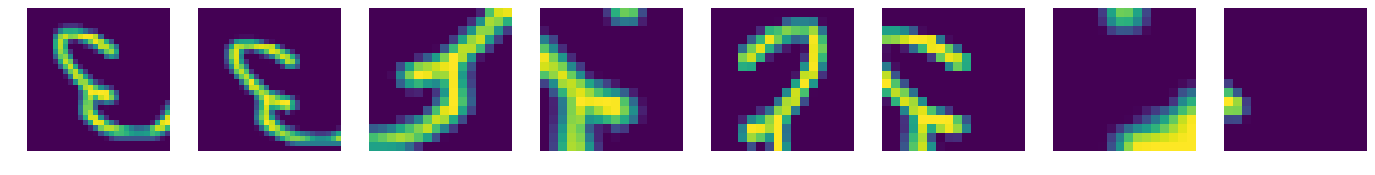

In [ ]:
learn.swav.show_one()

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(8.3728)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01-augmentations.ipynb.
Converted 02-layers.ipynb.
Converted 03-distributed.ipynb.
Converted 10-simclr.ipynb.
Converted 11-byol.ipynb.
Converted 12-swav.ipynb.
Converted 13-moco.ipynb.
Converted index.ipynb.
